Parts
---

- Loading training data
    -  Encoding characters into readable vectors
- Define the RNN
- Define a loss function (the real meat of the code is in the loss function)
    -  Forward pass
    -  Loss
    -  Backward pass
- Define a function to create sentences from the model
- Train the network
    -  Feed the network
    -  Calculate gradient and update the model


Load the training data
---

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import time

%matplotlib inline

# Data

data = open('oldman.txt', 'r').read()

chars = list(set(data))

data_size, vocab_size = len(data), len(chars)

print "Data has",data_size,  "total chars and",  vocab_size, "unique characters.", '\n'

char_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_char = {i:ch for i, ch in enumerate(chars)}



# Example One-hot Encoded

vector_for_char_a = np.zeros((vocab_size,1))
vector_for_char_a[char_to_int['a']] = 1
print "The one-hot input vector for 'a' is ", '\n\n', vector_for_char_a.ravel()


Data has 134984 total chars and 65 unique characters. 

The one-hot input vector for 'a' is  

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


# Hyperparameters

In [6]:
# Number of hidden layer neurons

hidden_size = 100

# Input sequence length

seq_length = 25

# How quickly a neural net abandons old beliefs for new ones 

learning_rate = 0.1 

# Model parameters

In [8]:

##
# Weight Matrices
##

# Input to hidden state

weights_x_h = np.random.randn(hidden_size,vocab_size) * 0.01 

# Weights from hidden state to hidden state

weights_h_h = np.random.randn(hidden_size,hidden_size) * 0.01

# Hidden to output

weights_h_y = np.random.randn(vocab_size,hidden_size) * 0.01 

##
# Biases
##

# Hidden state bias

bias_h = np.zeros((hidden_size,1))

# Output bias

bias_y = np.zeros((vocab_size,1))

##
# Dimensions
##

print "Input-to-hidden matrix dimensions", np.shape(weights_x_h)
print "Hidden-to-hidden matrix dimensions", np.shape(weights_h_h)
print "Hidden-to-output matrix dimensions", np.shape(weights_h_y)
print "Hidden bias dimensions", np.shape(bias_h)
print "Output bias dimensions", np.shape(bias_y)


Input-to-hidden matrix dimensions (100, 65)
Hidden-to-hidden matrix dimensions (100, 100)
Hidden-to-output matrix dimensions (65, 100)
Hidden bias dimensions (100, 1)
Output bias dimensions (65, 1)


Forward Pass
---

The forward pass uses the parameters of the model (weights_x_h, weights_h_h, bias_h, bias_y) to calculate the **next character** given a character from the training set.

The function below shows how the hidden state is calculated.

$$ \mathbf{h}_t = \phi(W_{xh}\mathbf{x}_t + W_{hh}\mathbf{h}_{t-1} + b_h)$$

Where:

$$\phi(x) = tanh(x) = \frac{sinh(x)}{cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$ 

and:

$$ \frac{dtanh(x)}{dx} = 1 - tanh^2(x) = 1 - tanh(x)\cdot tanh(x)$$

The output is calculated as follows:

$$ y_t = W_{hy}\mathbf{h_t} + b_y $$

### In words

The hidden state at time $t$ is the $TanH$ activation of the **sum** of the **dot product** of the *input-to-hidden-state weight matrix and the inputs*, and the **dot product** of the *hidden-to-hidden weight matrix and the hidden bias* 

The output is the sum of the **dot product** of the *hidden-state-to-output weight matrix and the hidden state* and the *output bias*

The probabilities are then normalised by exponentiating the outputs at time $t$ and the and dividing them by the sum of the exponentiated outputs

# TanH Function vs Sigmoid Activation Functions

([<matplotlib.lines.Line2D at 0x112b8c210>],
 [<matplotlib.lines.Line2D at 0x112c97bd0>])

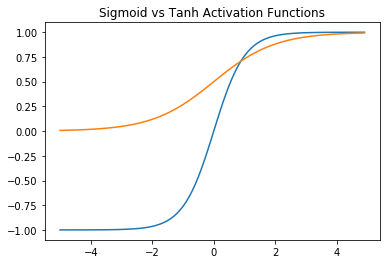

In [9]:


plot_x = np.arange(-5,5, 0.1)

plot_y = np.tanh(plot_x)



def sigmoid(x):
    return 1/(1+np.exp(-x))

plot_sig = np.array([sigmoid(x) for x in plot_x])
plt.title('Sigmoid vs Tanh Activation Functions')
plt.plot(plot_x, plot_y), plt.plot(plot_x, plot_sig)





# Loss
---

Negative log likelihood

$$ p_k = \frac{e^{f_k}}{\Sigma_j{e^{f_j}}} $$

$$ L_i = -log(p_{y_i}) $$

where:

$$ f_k = y_t =  W_{hy}\mathbf{h_t} + b_y $$



# Train
---

In [10]:
def train(inputs, targets, hprev):
    
    # Empty dictionaries for inputs (x), hidden state (h), outputs (y), and normalised probabilities (p)
    
    x_s = {}
    h_s = {}
    y_s = {}
    p_s = {}
    
    # Previous hidden state 
    
    h_s[-1] = np.copy(hprev)
    
    # Initialise loss
    
    loss = 0
    
    """Forward pass of inputs through network"""
    
    for t in xrange(len(inputs)):
        
        # Placeholder for inputs
        
        x_s[t] = np.zeros((vocab_size,1))
        
        # Set inputs to 1
        
        x_s[t][inputs[t]] = 1
        
        # Calculate hidden state
        
        h_s[t] = np.tanh(np.dot(weights_x_h, x_s[t]) + np.dot(weights_h_h,h_s[t-1]) + bias_h)
        
        # Calculate output (Unnormalized log probabilities)
        
        y_s[t] = np.dot(weights_h_y, h_s[t]) + bias_y 
        
        # Normalise output log probabilities
        
        p_s[t] = np.exp(y_s[t])/ np.sum(np.exp(y_s[t]))
        
        # Calculate softmax cross entropy loss
        
        loss += -np.log(p_s[t][targets[t],0])  
        
        
        
    """Backward pass: compute gradients"""
    
    # Placeholder vectors for gradient values for each set of weights. d = "delta" to indicate gradient
        
    d_weights_x_h = np.zeros_like(weights_x_h)
    d_weights_h_h = np.zeros_like(weights_h_h)
    d_weights_h_y = np.zeros_like(weights_h_y)
    
    # Placeholder for gradients of biases
    
    d_bias_h  = np.zeros_like(bias_h) 
    d_bias_y = np.zeros_like(bias_y)
    
    d_h_next = np.zeros_like(h_s[0])

    for t in reversed(xrange(len(inputs))):
        
        # output probabilities
        
        d_y = np.copy(p_s[t])

        # Derive our first gradient
        
        d_y[targets[t]] -= 1 #backprop into y
        
        # When we apply the transpose weight matrix we can think of it intuitively as moving the error backward
        
        # Gradient of the hidden-to-output weight matrix is updated by adding the dot product of transpose of the
        # hidden state and the gradient of the loss function wrt the output layer

        d_weights_h_y += np.dot(d_y, h_s[t].T)

        # Output bias

        d_bias_y += d_y 

        # Backpropagation
        
        # Backprop into hidden state

        d_h = np.dot(weights_h_y.T, d_y) + d_h_next 
        
        # backprop through TanH activation function
        
        d_h_raw = (1 - h_s[t]*h_s[t]) * d_h 
        
        # Gradient of hidden bias
        
        d_bias_h += d_h_raw 
        
        # Gradient of input-to-hidden matrix
        
        d_weights_x_h += np.dot(d_h_raw, x_s[t].T) 
        
        # Gradient of hidden-to-hidden
        
        d_weights_h_h += np.dot(d_h_raw, h_s[t-1].T) 
        
        #
        
        d_h_next = np.dot(weights_h_h.T, d_h_raw)

    # Vanishing Gradients Problem (Solution)

    for d_param in [d_weights_x_h, d_weights_h_h, d_weights_h_y, d_bias_h, d_bias_y]:
        
        np.clip(d_param, -5, 5, out = d_param) 
        

    return loss, d_weights_x_h, d_weights_h_h, d_weights_h_y, d_bias_h, d_bias_y, h_s[len(inputs) - 1]


# Sample Sentence from Model
---

In [14]:
def sample(h, seed_ix, n):
    """
    Sample a sequence of integers from the model
    h is memory state
    seed_ix is seed letter for first time
    n is how many characters to predict
    """
    
    # Placeholder for inputs
    
    x = np.zeros((vocab_size,1))
    
    # Set seed character
    
    x[seed_ix] = 1
    
    # List to store generated chars
    
    ixes = []
    
    # For as many characters as we want to generate
    
    for t in xrange(n):
        
        # Hidden state 
        
        h = np.tanh(np.dot(weights_x_h,x) + np.dot(weights_h_h,h) + bias_h)
        
        # Compute output 
        
        y = np.dot(weights_h_y, h) + bias_y
        
        # Probabilities for next characters (normalised)
        
        p = np.exp(y) / np.sum(np.exp(y))
        
        # pick one with highest prob
        
        ix = np.random.choice(range(vocab_size), p = p.ravel())
        
        # create a vector
        
        x = np.zeros((vocab_size, 1))
        
        # customize it for the predicted char
        
        x[ix] = 1
        
        # add it to the list
        
        ixes.append(ix)
        
    txt = ''.join(int_to_char[ix] for ix in ixes)
    
    print '----\n %s \n ---- ' % (txt,)
    
hprev = np.zeros((hidden_size,1)) # Reset RNN memory?

# predict the next 200 characters given 'a'

sample(hprev, char_to_int['a'],200)


----
 TGJHUtf_HynS�ty"[vdKg
glkG?![leaSuV,h!tCcV!OOWbA
NbCIIC FhJymtoaBgRRyaS-wtb,E]t:!v-UcgufyL[vVlIf[VsFv
Otk_f jKij:U
xL-_BLuMTljDSPmgogOTdA[:U]MuWnhJ:Y"YIi;cnYw_�JVrz;aVqW,zTJ
DoxBwlx'oL!?dTUHWyxdO;aNRC 
 ---- 


Training
---

- Feed the network some portion of the file. Size of chunk is *seq_length*
- Use the loss function to:
    - Do forward pass to calculate all parameters for the model for a given input
    - Do backward pass to calculate gradients
- Print a sentence from a random seed using the paramters of the network
- Update the model using Adaptive Gradient technique Adagrad



### Feed the Loss function with inputs and targets

Create two array of char from the data file, the targets one is shifted

For each char in the input array, the target array give the char that follows

In [16]:
p = 0
inputs = [char_to_int[ch] for ch in data[p:p+seq_length]]

print 'inputs', inputs

targets = [char_to_int[ch] for ch in data[p+1:p+seq_length+1]]

print 'targets', targets

inputs [32, 20, 15, 3, 25, 24, 16, 3, 23, 12, 26, 3, 12, 26, 16, 3, 32, 20, 15, 3, 29, 15, 12, 1, 1]
targets [20, 15, 3, 25, 24, 16, 3, 23, 12, 26, 3, 12, 26, 16, 3, 32, 20, 15, 3, 29, 15, 12, 1, 1, 1]


### Adagrad to update the parameters

$$ \theta_{t+1,i} = \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,ii} + \epsilon}} \cdot g_{t,i} $$

where:

$ \eta = learning rate $  
$ G = previous gradients $  
$\triangledown $

`step size = learning rate`

The easiest technique to update the paramters of the model is this:

`param += dparam * step_size`

Adagrad is a more efficient technique where `step_size` is getting smaller during learner

Uses a memory varaible that grows over time:

`mem += dparam * dparam`

And use it to calculate the step size:

`step_size = 1./np.sqrt(mem + 1e-8)`

More info here:

http://ruder.io/optimizing-gradient-descent/


Implement
---

iter 0, loss: 104.346798


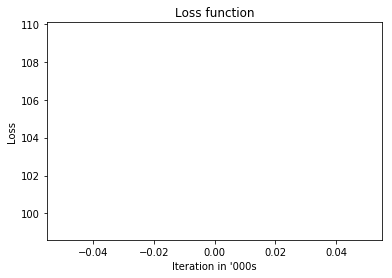

----
 Efirindn asix cants wEind tHidd Serap id tUatrhin nnanis ssaragar Dnin ndo Darly loEE I
He man nEo an deyGmilf yaid TTYar is i yerainge
fire ly  HI thane nttea falf HEin a
soe lenay an mEind i
I findr 
 ---- 
iter 1000, loss: 77.611783


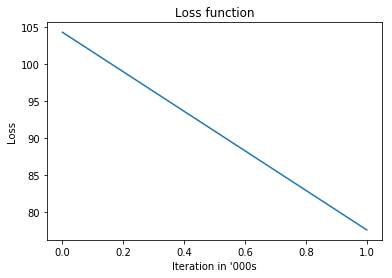

----
 apl wole hoqne
Boidan, the fous ay the mynthit fof ceike
pougacdtst the there sok.  me
he want mwertir the gan ige woy ofd ang las weide lar oks mhe the alk werisp the cad ta sapus fesyebe the hal ric 
 ---- 
The average time for 1000 iterations is 3.95 seconds
The time remaining is 6.51 minutes.
iter 2000, loss: 64.067565


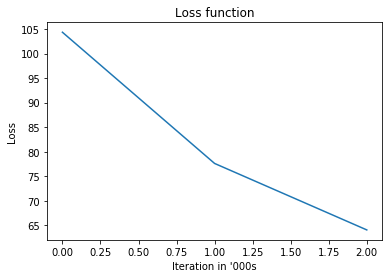

----
 e
"RDam swing if frit he wang wot the a a cead iculastad puf uf,  He bbomh mnofed sa id the ho
cee
ptif Iome
her oln thut os werm tarlas Nindmam nighe;
thism. "I cuks.  Ne he the thaalid thow jofs thr 
 ---- 
The average time for 1000 iterations is 5.43 seconds
The time remaining is 8.87 minutes.
iter 3000, loss: 58.723261


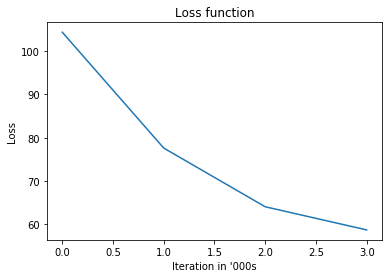

----
 nd nee anesid how.  I
ho finellin oim and the haaf thees thot tthe hrind aghe un anf ig Shand ilbe wilast
varinl habig I mroon
Hann avomr igeed af he thas shee be he bas lay
mork dYave hid alg In'lada 
 ---- 
The average time for 1000 iterations is 4.16 seconds
The time remaining is 6.72 minutes.
iter 4000, loss: 54.679400


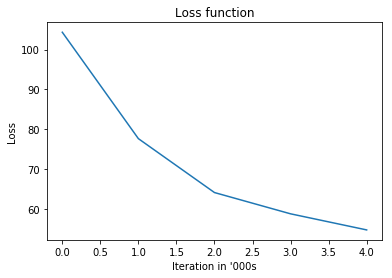

----
 d he whe bos and him
rrone he bafty lim son winnsnereff wisfich he freinuss has thut wounfd rut low them annt.  Neliger bef
the daf  Mand pundis fwork_. then.  Buged dom nasage.  it
the oin.  Tould la 
 ---- 
The average time for 1000 iterations is 5.99 seconds
The time remaining is 9.58 minutes.


KeyboardInterrupt: 

In [22]:
%matplotlib inline

# Initialise "memory" variables

n = 0
p = 0

m_weights_x_h = np.zeros_like(weights_x_h)
m_weights_h_h = np.zeros_like(weights_h_h)
m_weights_h_y = np.zeros_like(weights_h_y)

# Bias memory variables

m_bias_h = np.zeros_like(bias_h)
m_bias_y = np.zeros_like(bias_y) 

# Smooth loss

smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration


losses = []

time_elapsed = []

start_time = time.time()

while n<= 1000*100:
    
    if p+seq_length +1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_int[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_int[ch] for ch in data[p+1:p+seq_length+1]]
    
    # Determine loss, gradients, and hidden state
    
    loss, d_weights_x_h, d_weights_h_h, d_weights_h_y, d_bias_h, d_bias_y, hprev = train(inputs, targets, hprev)
    
    # Smooth the loss function 
    
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    
    
    # Sample from model
    
    if n % 1000 == 0:
        print 'iter %d, loss: %f' % (n, smooth_loss) # print progress
        losses.append(smooth_loss)
        #print losses
        plt.plot(losses)
        plt.title('Loss function')
        plt.ylabel('Loss')
        plt.xlabel("Iteration in '000s")
        plt.show()
        sample(hprev, inputs[0], 200)
        time_elapsed.append(time.time() - start_time)
        if len(time_elapsed) > 1:
            average_time = time_elapsed[-1]-time_elapsed[-2]
            print "The average time for 1000 iterations is", round(average_time,2) , "seconds"
            print "The time remaining is", round((((100000-n)/1000)*(average_time))/60,2), "minutes."

        
        
        
    # perform paramter update with Adagrad
    
    for param, d_param, mem in zip([weights_x_h, weights_h_h, weights_h_y, bias_h, bias_y],
                                   
                                 [d_weights_x_h, d_weights_h_h, d_weights_h_y, d_bias_h, d_bias_y],
                                   
                                 [m_weights_x_h, m_weights_h_h, m_weights_h_y, m_bias_h, m_bias_y]):
        
        
        mem += d_param * d_param
        param += -learning_rate * d_param / np.sqrt(mem + 1e-8) # 
        

    

        
    p += seq_length # move data pointer
    n += 1 # iteration counter
    

        